Presenting the results from the galaxy type classification. 
First I load the data. 

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
import time
import random as random
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss, ConfusionMatrixDisplay
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression
from functions_ml import *
import pickle

Below I get the data, which is produced by the program get_zoo_galaxies.py.  The is applied  43 times and thus gets data from 43 fields. This fields cover the area from 310 (-50) degree to 60 degree in right ascension with a height from -1.26 to +1.26  degree in Declination. 

The data consist of two pieces, firstly the images, which were saved as 4 dimensions (1 dimension x of image, second y of image, third channels, forth image in order or batch on torch language) numpy arrays, because torch needs 4d arrays, even when as here only a single channel exist. The image are rdeep images from http://research.iac.es/proyecto/stripe82/pages/data.php
This channel is the channel combination with the highest snr. Secondly information on each iamges is loaded as data frame, that are in particular the calseses spiral and elliptical which are bollean and exclusive here. There are citizen zoo classifications from the zoo projects. Only rather certain ones I included here, but there is no 100% certainty. 

In [2]:
#getting the list of images
myPath='/home/tobias/ml-testing/astr-images'
list_images=[f for f in os.listdir(myPath) 
    if f.endswith('_ell_spiral_im.npy') ]
list_images.sort()
#getting the list of tables 
list_tables=[f for f in os.listdir(myPath) 
    if f.endswith('_ell_spiral_table.csv')]
list_tables.sort()

I combine the images and the data frames, with the classifications and more meta data. 

In [3]:
#images
cutouts=comb_nump_4d(list_images)
#dataframes 
list_df=[]
for i in range(len(list_tables)):
    i=pd.read_csv(list_tables[i])
    list_df.append(i)  
print(f"number of tables is {len(list_df)}") 
df=pd.concat(list_df,ignore_index=True)
print(f"shape of combined data frame {df.shape}")
print(f"shape of image file is {cutouts.shape}")

number of tables is 43
shape of combined data frame (7875, 51)
shape of image file is (43, 43, 1, 7875)


The images and the classification data has the same lengths. Now I am looking on classes.

In [4]:
print(df.spiral.value_counts())

1    5766
0    2109
Name: spiral, dtype: int64


The classes are somewhat inbalanced, the ones which are not spiral are ellipticals. 

Next I display some examples. There arer two classes of galaxies, elliptical and Spiral.

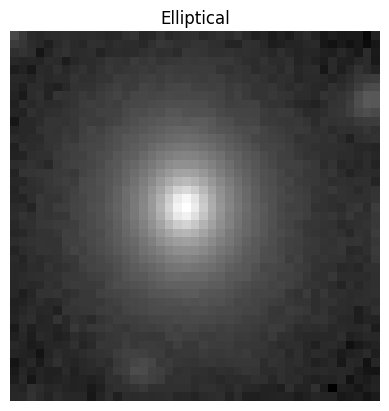

In [5]:
x=0
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(cutouts[:,:,0,x])**0.25,cmap=cm.gray, interpolation='nearest')

This elliptical is rather round, but others are more elongated but never exteremly. 

Spiral look rather different dependent on the angle, they are viwed on. 

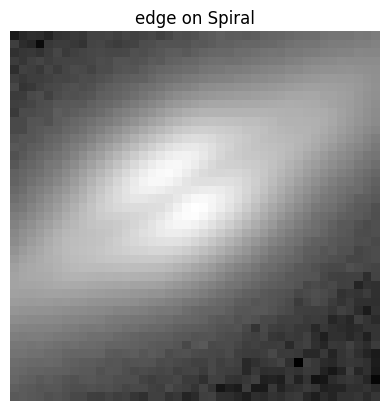

In [6]:
x=7870
plt.axis('off')
plt.title(f"edge on Spiral")
plt.imshow(abs(cutouts[:,:,0,x])**0.25,cmap=cm.gray, interpolation='nearest')

The dark strip in the center is not always visible in practice. 

The name giving spiral structure is visible face on. 

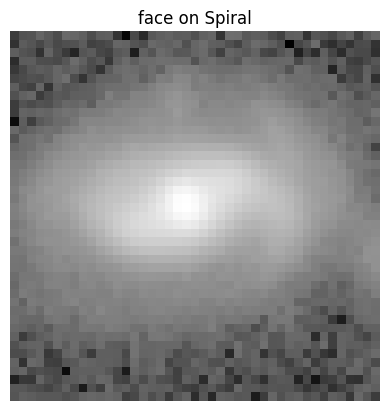

In [7]:
x=18
plt.axis('off')
plt.title(f"face on Spiral")
plt.imshow(abs(cutouts[:,:,0,x])**0.125,cmap=cm.gray, interpolation='nearest')

However, some spirals only display other deviations from the simple structures of ellipticals, like by a ring in the following case. 

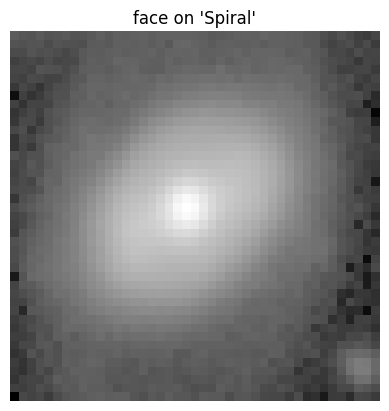

In [8]:
x=7874
plt.axis('off')
plt.title(f"face on 'Spiral'")
plt.imshow(abs(cutouts[:,:,0,x])**0.15,cmap=cm.gray, interpolation='nearest')

Thus, it is clear that there is a variation in structure between different examples of the same class. 

Next I add the image pixel information to the data frame, these data will be used by the algorithms which do not work on images but on tables. I Just run run two lopps within each other, thus the order is not particular meaningful. This does not matter much since the algorithm find the connections themself and or do not connect different features et al. 

In [9]:
x=0
for i in range(cutouts.shape[0]):
    for j in range(cutouts.shape[1]):
        df[x]=cutouts[i,j,0,:]
        x+=1
print(df)    
#there are warnings but it works 

/tmp/ipykernel_14447/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_14447/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_14447/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[

/tmp/ipykernel_14447/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_14447/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_14447/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[

/tmp/ipykernel_14447/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_14447/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_14447/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[

      Unnamed: 0  index                objid          ra       dec  psfMag_u  \
0              0      1  1237663237128388701   50.130513 -1.228488  22.01211   
1              1    123  1237666299481817102   50.160628 -1.035026  19.01124   
2              2    140  1237663237128388949   50.167304 -1.241885  22.36878   
3              3    458  1237666300018557091   50.006004 -0.495751  21.98376   
4              4    110  1237663238739067202   50.387910  0.198944  21.86834   
...          ...    ...                  ...         ...       ...       ...   
7870         101    101  1237663543675126583  312.305638  0.325466  21.65428   
7871         102    243  1237663543675060734  312.252401  0.351028  21.40535   
7872         103    257  1237678596459004706  312.353091  0.906897  20.69301   
7873         104    263  1237678596459070093  312.482143  0.899587  20.42247   
7874         105      8  1237678617933840840  312.415661  0.836877  21.30678   

      psfMag_g  psfMag_r  psfMag_i  psf

/tmp/ipykernel_14447/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_14447/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_14447/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[

Next I am splitting the data set into test and train. There are two feature variants, one is the standard tables for everything beisdes convolutional network and the other is the image data set for everything else. 

In [10]:
#images_test/train are feature for vonvolutional network 
feature_train, feature_test, target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df.iloc[:,51:1900],df.loc[:,"spiral"],cutouts.T,df,train_size=0.60, shuffle=True, random_state=1)
print("shape of image train data is")
print(image_train.shape)

shape of image train data is
(4725, 1, 43, 43)


I use 4 different algorithms, two not neural networks, these are logistic regression and XGBoost. Secondly, two neural networks, a multi layer perceptron and a convolutional network. In all besides the convolutional network the image is structure is not preserved but flattened to a single vector. 

Standard setting lead to overfitting as visible in clearly better classifications in trian than in test.

The data set does not have so many parameters. Thusd, I optimize only one paramtere. I choose l2 regularization since it exists for all. I change the values in steps of 1, 3, 10 and so on. 

In case of the network convergence is not fats happening and the sometimes not so good results are saved. To select a good I combine several results. I choose the train set to select the best for one given regularization, that way I can still use test to choose the best regularization. I use log=loss for minization as the fitting algorthm does. 

In [11]:
stats_mlp1=expand_2_output("mlp_4n_v2_full_gal_240.txt")
stats_mlp2=expand_2_output("mlp_4n_v2_full_gal_400.txt")
stats_mlp3=expand_2_output("mlp_4n_v2_full_gal_100.txt")
stats_mlp4=expand_2_output("mlp_4n_v2b_full_gal_300.txt")
stats_mlp5=expand_2_output("mlp_4n_v2b_full_gal_360.txt")
stats_mlp6=expand_2_output("mlp_4n_v2b_full_gal_440.txt")
stats_mlp7=expand_2_output("mlp_4n_v2b_full_gal_370.txt")
stats_mlp8=expand_2_output("mlp_4n_v2b_full_gal_460.txt")

stats_conv1=expand_2_output("conv2d_4n_v2_full_gal_240.txt")
stats_conv2=expand_2_output("conv2d_4n_v2b_full_gal_360.txt")
stats_conv3=expand_2_output("conv2d_4n_v2b_full_gal_340.txt")
stats_conv4=expand_2_output("conv2d_4n_v2b_full_gal_350.txt")
list_per=[stats_mlp1,stats_mlp2,stats_mlp3,stats_mlp4,stats_mlp5,stats_mlp6,stats_mlp7,stats_mlp8]
stats_mlp=combine_fit_results(list_per,minimise='log_loss_train')
list_conv=[stats_conv1,stats_conv2,stats_conv3,stats_conv4]
stats_conv=combine_fit_results(list_conv,minimise='log_loss_train')

I get now also the files from the other algorithm and then plot all, first the F1 score. The F1 score consider all kind of missclassifications, the best score is 1.0.

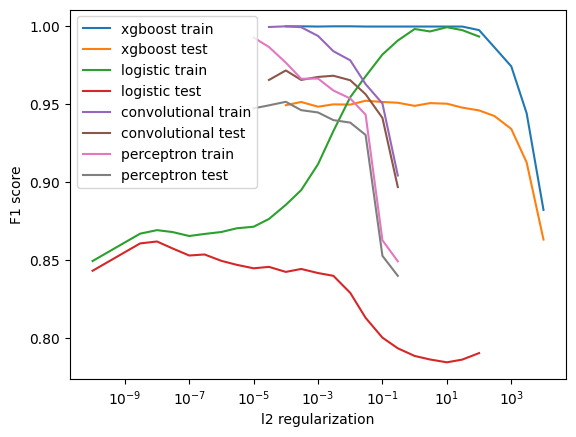

In [12]:
stats_xgb=np.loadtxt("xgb_43sets_gal-type_v1.txt")
stats_log=np.loadtxt("log_43sets_gal-type_v1.txt")

plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.plot(stats_conv[0],stats_conv[1],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[2],label='convolutional test')
plt.plot(stats_mlp[0],stats_mlp[1],label='perceptron train')
plt.plot(stats_mlp[0],stats_mlp[2],label='perceptron test')
plt.legend(loc="best")

plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")

Logistic is clearly worse than the rest, I now zoom in that differences between the others are better visibile.

(0.92, 1.001)

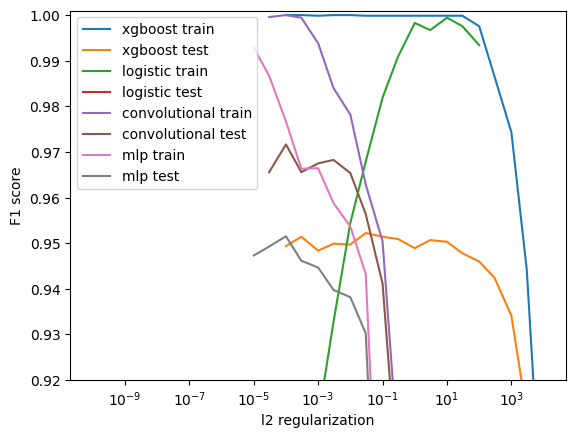

In [13]:

plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.plot(stats_conv[0],stats_conv[1],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[2],label='convolutional test')
plt.plot(stats_mlp[0],stats_mlp[1],label='mlp train')
plt.plot(stats_mlp[0],stats_mlp[2],label='mlp test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")
plt.ylim(0.92,1.001)

The multi layer perceptron has the smallest F1 in train, thus it is likely not fully converged or smaller regularization are needed to explore. Possible they can be obtained with a different optimization strategy. For logistic a too small number of iterations causes a not perfect F1 score for the right most points. However, that is not real problem, since performance in test is what matters. 

Convolutional network has the highest F1 score for test, xgboost and multi layer percetron have similar goodness in the F1 score. All peaks are rather broad and in case of the neural networks likely influenced by the number of iterations and randomness. 

I am now looking on log loss. I zoom in to ignore the worst part of logistic. 

(0.0, 0.6)

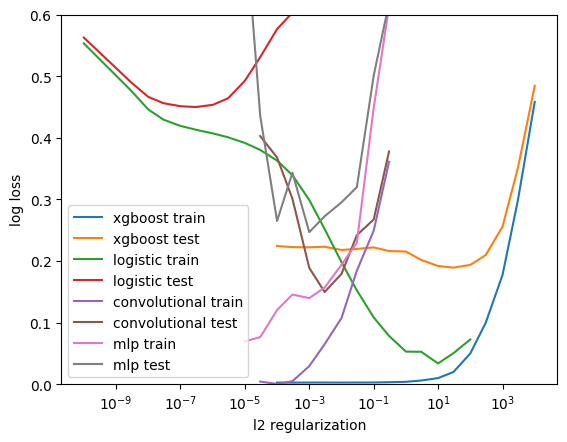

In [14]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.plot(stats_conv[0],stats_conv[3],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[4],label='convolutional test')
plt.plot(stats_mlp[0],stats_mlp[3],label='mlp train')
plt.plot(stats_mlp[0],stats_mlp[4],label='mlp test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")
plt.ylim(0,0.6)

Here the minima are clearer. Thus I use it to choose them. The F1 score is still close to the best since the minima are broad for it.
The best model is convolutional network, then xgbboost and then perceptron network and logistic is clearly worst.

I now load the bets models which I saved before. 

In [15]:
#logistic
log_single = pickle.load(open('best_log_single.sav', 'rb'))
#xgboost
xgb_single=XGBClassifier()
xgb_single.load_model("xgboost_model_spiral_ell_v1.json")
#convolutional network
PATH='conv2d_2layers_reg0.003_300epochs.pkl'
conv_single =CNNBinary4(1)
conv_single.load_state_dict(torch.load(PATH))
conv_single.eval()
#multilayer perceptron
PATH2='mlp_4layers_reg0.001_400epochs.pkl'
mlp_single =BinaryClassification4(1849)
mlp_single.load_state_dict(torch.load(PATH2))
mlp_single.eval()

/home/tobias/ml-testing/astr-images/functions_ml.py:123: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) # initialize parameters


BinaryClassification4(
  (fc1): Linear(in_features=1849, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)

I then get the predictions for test and train for all models.

In [16]:
#transforming into torch data structure
target_train, target_test = np.array(target_train), np.array(target_test)
feature_train, feature_test = np.array(feature_train), np.array(feature_test)
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)
m_test_pred=pred_torch(mlp_single,test_loader)
m_train_pred=pred_torch(mlp_single,train_loader_pred)
c_test_pred=pred_torch(conv_single,test_im_loader)
c_train_pred=pred_torch(conv_single,train_im_loader_pred)
x_train_pred=xgb_single.predict_proba(feature_train)
x_test_pred=xgb_single.predict_proba(feature_test)
l_train_pred=log_single.predict_proba(feature_train)
l_test_pred=log_single.predict_proba(feature_test)

Next I make confusion matrix and display them. First Logistic in train. 

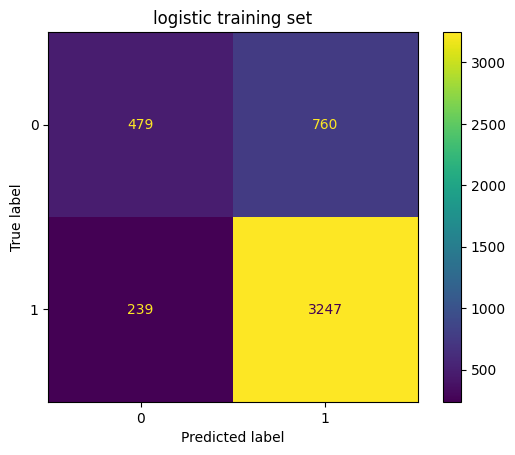

In [17]:
l_conf_train = confusion_matrix(target_train, np.round(l_train_pred[:,1]), labels=log_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=l_conf_train,
                               display_labels=log_single.classes_)
disp.plot()
plt.title(f"logistic training set")
plt.show()

It is visisble, that the rarer class (elliptical) is in majority wrong classified. It is often the case the rare class is more difficult to classify, but that is clearly too bad to be accpetable, thus I look on the test set is not needed in this case. 

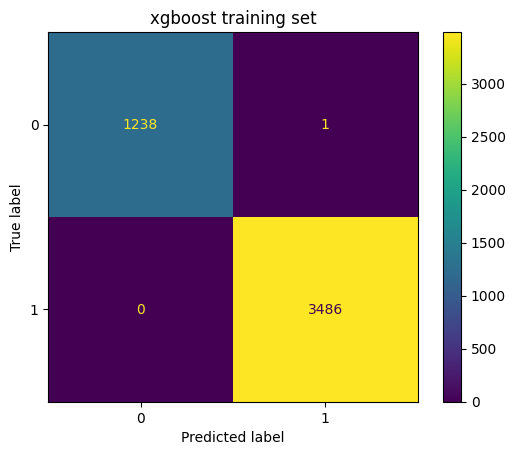

In [18]:
x_conf_train = confusion_matrix(target_train, np.round(x_train_pred[:,1]), labels=xgb_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=x_conf_train,
                               display_labels=xgb_single.classes_)
disp.plot()
plt.title(f"xgboost training set")
plt.show()

Xgboost is much better, only one missclassification, but that is good that it is neraly certainly overfitting that is likely overfitting. Thus, I look on the test set now. 

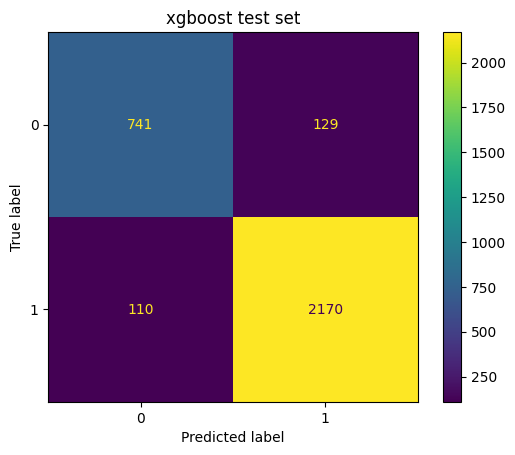

In [19]:
x_conf_test = confusion_matrix(target_test, np.round(x_test_pred[:,1]), labels=xgb_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=x_conf_test,
                               display_labels=xgb_single.classes_)
disp.plot()
plt.title(f"xgboost test set")
plt.show()

Clearly more are missiclassified in tets, but still alos in the rarer class, only about 1/6 are missclassified. 

Now to the neural network, only test now, since train is too influenced by overfitting.

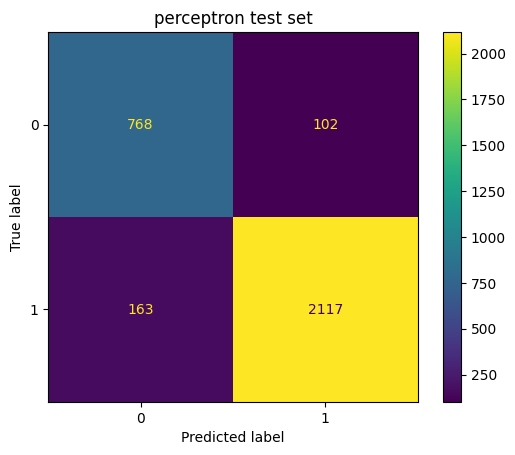

In [20]:
m_conf_test = confusion_matrix(target_test, np.round(m_test_pred[:]), labels=xgb_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=m_conf_test,
                               display_labels=xgb_single.classes_)
disp.plot()
plt.title(f"perceptron test set")
plt.show()

Similar good as xgboost overall but some differenced, the predidcted class 0 are purer, and the reverse is true for the more common class 1 (spirals).

Last the convolutional network. 

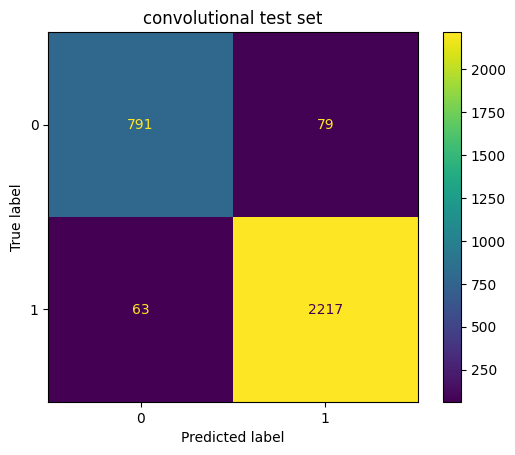

In [21]:
c_conf_test = confusion_matrix(target_test, np.round(c_test_pred[:]), labels=xgb_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_conf_test,
                               display_labels=xgb_single.classes_)
disp.plot()
plt.title(f"convolutional test set")
plt.show()

This is clearly best in all possible metrics. 

Next I look on some missclassified cases to indetify problems in classification. The true classification is displayed at the top. In red when it is not renognised in green when it is found. 

First logistic the controll is convolutional since it is best. In the top as comment I indicate my per eye classification since it is not clear that all input classifications are correct. 

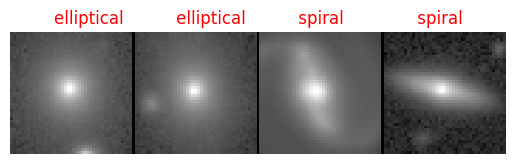

In [22]:
#elliptical, elliptical, spiral, spiral 
plot_images(image_test,target_test,c_test_pred,[0,1,2,3],prediction2=l_test_pred[:,0],scale=0.25, different=True)

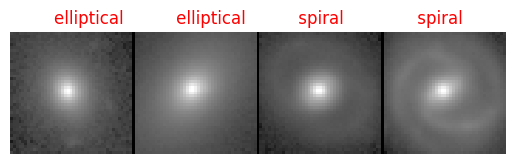

In [24]:
#elliptical, elliptical, spiral, spiral 
plot_images(image_test,target_test,c_test_pred,[4,5,6,7],prediction2=l_test_pred[:,0],scale=0.25,different=True)

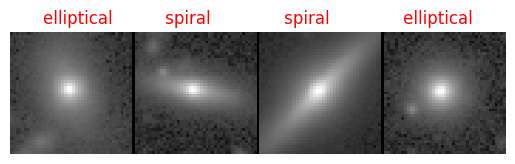

In [29]:
##elliptical, spiral, spiral, eliptical.
plot_images(image_test,target_test,c_test_pred,[8,9,10,11],prediction2=l_test_pred[:,0],scale=0.25,different=True)

I agree with all automatical classifications here. Many missclassifications are elliptical for them the main reason is likely that as the minor close there are more often  missclassified. In case of missclassified spirals it is visible, that many are edge on spirals. That is not surprising, when they are minority of all spirals, since they are clearly different from face on spirals and logistic cannot combine different subclasses when they are more different between each other than to the other class. 

Below I look on correct classifications. 

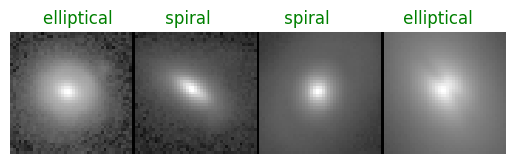

In [25]:
plot_images(image_test,target_test,c_test_pred,[0,1,2,3],prediction2=l_test_pred[:,0],scale=0.25, different=False)

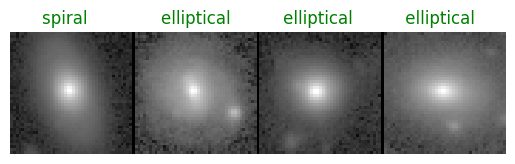

In [26]:
plot_images(image_test,target_test,c_test_pred,[4,5,6,7],prediction2=l_test_pred[:,0],scale=0.25,different=False)

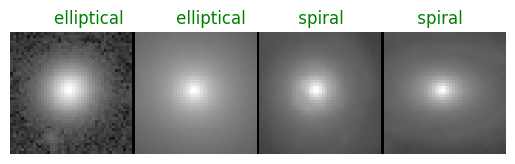

In [27]:
plot_images(image_test,target_test,c_test_pred,[8,9,10,11],prediction2=l_test_pred[:,0],scale=0.25,different=False)

In general they seem less extreme but are not usually very clear spirals. 

Next I look on xgboost classifications.

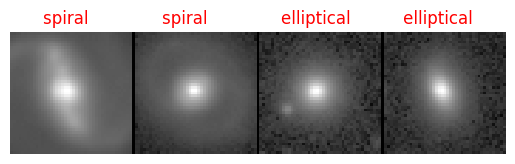

In [30]:
plot_images(image_test,target_test,c_test_pred,[0,1,2,3],prediction2=x_test_pred[:,0],scale=0.25,different=True)

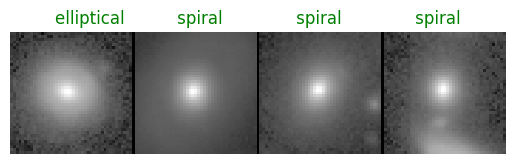

In [31]:
plot_images(image_test,target_test,c_test_pred,[0,1,2,3],prediction2=x_test_pred[:,0],scale=0.25,different=False)
#some thing wrong later to improve

Now looking on convoltional network results, the best method. First some correct classified ones. 

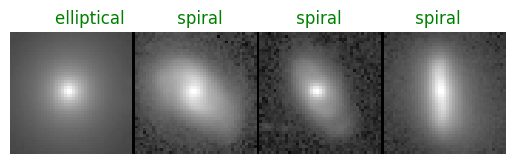

In [36]:
#all correct
plot_images(image_test,target_test,c_test_pred,[0,1,2,3],scale=0.25,different=False,single=True)

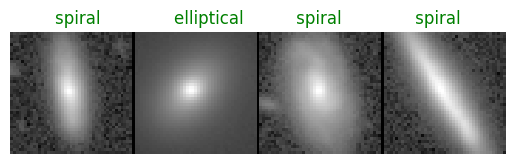

In [35]:
#all correct
plot_images(image_test,target_test,c_test_pred,[4,5,6,7],scale=0.25,different=False,single=True)

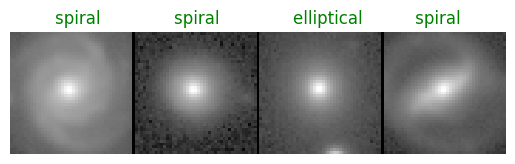

In [37]:
#spiral, possible elliptical, elliptical, spiral
plot_images(image_test,target_test,c_test_pred,[8,9,10,11],scale=0.25,different=False,single=True)

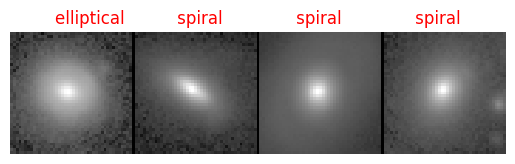

In [40]:
#spiral?, spiral, spiral, elliptical
plot_images(image_test,target_test,c_test_pred,[0,1,2,3],scale=0.25,different=True,single=True)

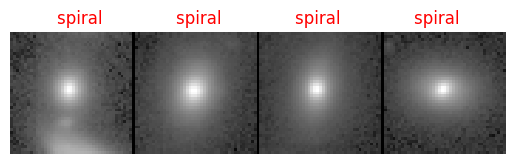

In [41]:
#ellipitical, elliptical, spiral?, spiral
plot_images(image_test,target_test,c_test_pred,[4,5,6,7],scale=0.25,different=True,single=True)

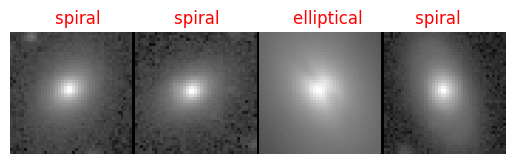

In [43]:
#elliptical, elliptical, spiral?, spiral 
plot_images(image_test,target_test,c_test_pred,[8,9,10,11],scale=0.25,different=True,single=True)

Most are difficult to classify per eye. While it is possible for some the features are outside the used window, it is unlikely. It is also possible that these are truly missclassified, since this classification was done by different citizen scientist and is thus not homogenous. It also used less deep data, thus when here very weak feature are visible they were likely not visible in the original images. 
 

With 7875 examples (of which not all are in the training set), the data set is not much larger than the number of features per example of 1849. It is not possible to add more examples to the dat set since either the image or the classfication quality decreases with an expansion. Therefore I use data augmenation as method. I considered using data with added noise, but this actually decreases the scores in our case.

I then looked into an0other option. On the sky the orientation of images and thus galaxies is meningless. Thus, a simple methods to imncrease the training set by data augmentation is to add rotated and mirrored versions. That adds 7 more cases for our quadratic image and ythsun quadruples the data sets. 


There can done this augmentation in two steps in the training and in the test. First I look how it matters in training. I show the results in test here, since training is usually overfit. 

(5, 15) (5, 4)


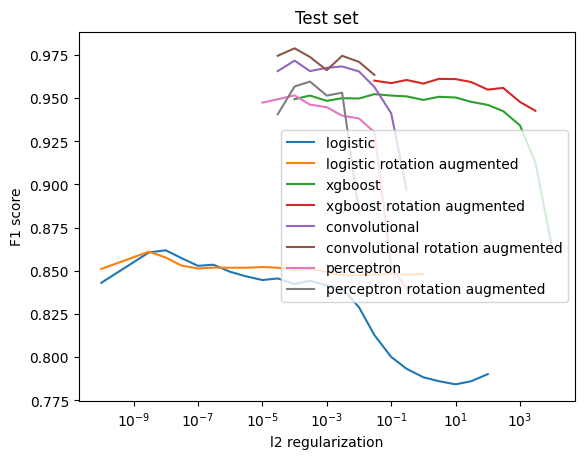

In [160]:
stats_xgb2=np.loadtxt("xgb_rotmir_mode0.txt")
stats_log2a=np.loadtxt("log_43sets_gal-type_mirr_rot_v1.txt")
stats_log2b=np.loadtxt("log_43sets_gal-type_mirr_rot_v2.txt")
#combine 2 inputs
print(stats_log2a.shape,stats_log2b.shape)
stats_log2=np.zeros((5,stats_log2a.shape[1]+stats_log2b.shape[1]))
stats_log2[:,0:15]=stats_log2a
stats_log2[:,15:19]=stats_log2b
stats_mlp2a=np.loadtxt("mlp_fits_all_stats.txt")
stats_conv2a=np.loadtxt("conv_fits_all_stats.txt")
bestlossmlp=combine_fit_results2(stats_mlp2a,1,minimise='log_loss_train')
bestlossconv1=combine_fit_results2(stats_conv2a,1,minimise='log_loss_train')
bestlossconv0=combine_fit_results2(stats_conv2a,0.75,minimise='log_loss_train')

plt.plot(stats_log[0],stats_log[2],label='logistic ')
plt.plot(stats_log2[0],stats_log2[2],label='logistic rotation augmented')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost')
plt.plot(stats_xgb2[0],stats_xgb2[2],label='xgboost rotation augmented')
plt.plot(stats_conv[0],stats_conv[2],label='convolutional ')
plt.plot(bestlossconv0[0],bestlossconv0[5],label='convolutional rotation augmented')
plt.plot(stats_mlp[0],stats_mlp[2],label='perceptron')
plt.plot(bestlossmlp[0],bestlossmlp[5],label='perceptron rotation augmented')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")

The F1 score improves for most, the execption is logistic, which we mpstly ignore form now on since it is clearly the worst. The improvments get better visible in the zoom below. 

(0.92, 0.98)

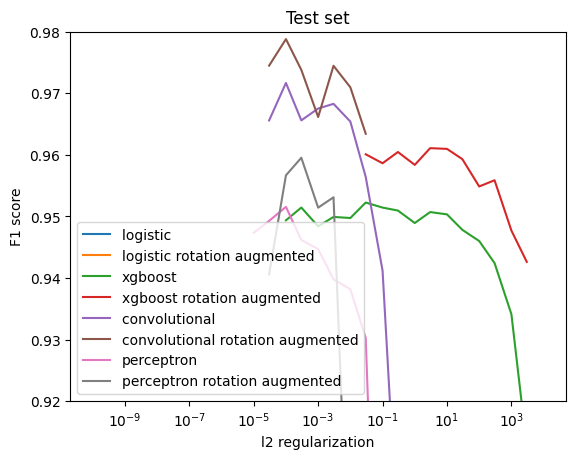

In [164]:

plt.plot(stats_log[0],stats_log[2],label='logistic ')
plt.plot(stats_log2[0],stats_log2[2],label='logistic rotation augmented')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost')
plt.plot(stats_xgb2[0],stats_xgb2[2],label='xgboost rotation augmented')
plt.plot(stats_conv[0],stats_conv[2],label='convolutional ')
plt.plot(bestlossconv0[0],bestlossconv0[5],label='convolutional rotation augmented')
plt.plot(stats_mlp[0],stats_mlp[2],label='perceptron')
plt.plot(bestlossmlp[0],bestlossmlp[5],label='perceptron rotation augmented')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")
plt.ylim(0.92,0.98)

The improvement is clearesr in xgboost becauise that is always converged, but also the networks improve. Next I look on log loss. 

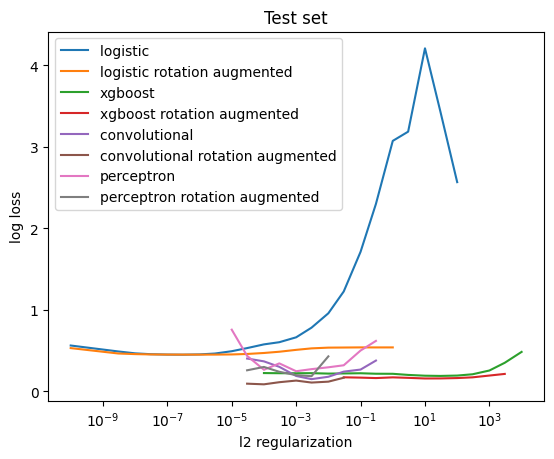

In [165]:

plt.plot(stats_log[0],stats_log[4],label='logistic ')
plt.plot(stats_log2[0],stats_log2[4],label='logistic rotation augmented')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost')
plt.plot(stats_xgb2[0],stats_xgb2[4],label='xgboost rotation augmented')
plt.plot(stats_conv[0],stats_conv[4],label='convolutional ')
plt.plot(bestlossconv0[0],bestlossconv0[7],label='convolutional rotation augmented')
plt.plot(stats_mlp[0],stats_mlp[4],label='perceptron')
plt.plot(bestlossmlp[0],bestlossmlp[7],label='perceptron rotation augmented')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")

Logistic does not improve at the optimumm , just at the less good values. Again we zoom into the better values, ignoring logistic. 

(0.0, 0.4)

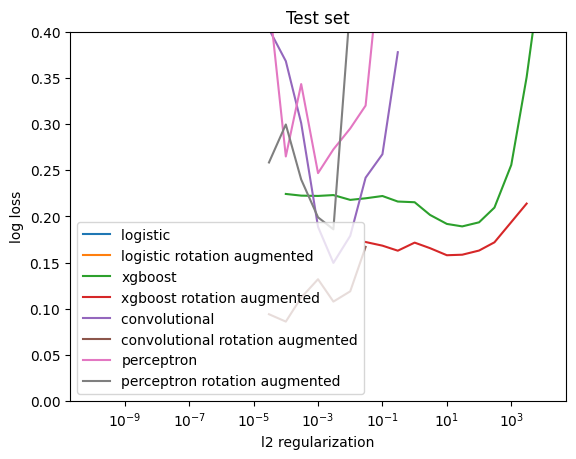

In [168]:

plt.plot(stats_log[0],stats_log[4],label='logistic ')
plt.plot(stats_log2[0],stats_log2[4],label='logistic rotation augmented')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost')
plt.plot(stats_xgb2[0],stats_xgb2[4],label='xgboost rotation augmented')
plt.plot(stats_conv[0],stats_conv[4],label='convolutional ')
plt.plot(bestlossconv0[0],bestlossconv0[7],label='convolutional rotation augmented')
plt.plot(stats_mlp[0],stats_mlp[4],label='perceptron')
plt.plot(bestlossmlp[0],bestlossmlp[7],label='perceptron rotation augmented')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")
plt.ylim(0,0.4)

There is similar improve for most values, still convolutional is best then xgboost slightly better than the percptron.
The convolutional network, does not anymore has a clear minimum because in the used fits keep prob was set to 0.75, which has the effect of much overfitting. 

After looking on the training/test dat set I now apply the models on other data, which can bhave more uncertain classifications or other less ideal properties.   

I build a function to apply the models to it. I ignore the option logistic, because it is clearly worse than the other two. 

In [54]:
#parameters, list of images, list of data frames with classes, model name, iamge output , frame output? 
def predict_probs(images,classes,model,modelname='convolutional',keep_prob=1,num_features=1849,image_output=True,df_output=True):
    cutouts_new=comb_nump_4d(images).T
    print(cutouts_new.shape)
    list_df2=[]
    for i in range(len(classes)):
        i=pd.read_csv(classes[i])
        list_df2.append(i)  
    print(f"number of tables is {len(list_df2)}") 
    df2=pd.concat(list_df2,ignore_index=True)
    print(f"shape of combined data frame {df2.shape}")
    print(f"shape of image file is {cutouts_new.shape}")
    #if not convolutional add image columns to daat frame 
    if model!='convolutional':
        x=0
        for i in range(cutouts_new.shape[2]):
            for j in range(cutouts_new.shape[3]):
                df2[x]=cutouts_new[:,0,i,j]
                x+=1
    print(df2.shape)  
    image_rot,target_rot,df_rot=get_rot_mirror_all(cutouts_new,df2.ra,df2.iloc[:,0:52],shuffle=False)
    if modelname=='xgboost':
        #overwrite not use ones
        #image_rot=0
        target_rot=0
        xgb_reg=XGBClassifier()
        xgb_reg.load_model(model)
        pred_si=xgb_reg.predict_proba(df_rot.iloc[:,52:1901])
        #combine the 8 rotation entries 
        predboth=comb_entries(pred_si,8,avg=True)
        pred=predboth[:,1]
        print(df_rot.columns[52:1901],pred.shape)
    if modelname=='convolutional':
        #df_rot=0
        #setup data for torch 
        train_imrot_dataset = ClassificationDataset(torch.from_numpy(image_rot).float(), torch.from_numpy(np.array(target_rot)).float())
        train_imrot_loader_pred = DataLoader(dataset=train_imrot_dataset, batch_size=1)
        keep_prob=keep_prob
        model_convfin =CNNBinary4(keep_prob)
        model_convfin.load_state_dict(torch.load(model))
        model_convfin.eval()

        pred_si=pred_torch(model_convfin,train_imrot_loader_pred)
        pred=comb_entries(np.array(pred_si),8,avg=True)    
    if modelname=='perceptron':
        #df_rot=0
        #setup data for torch 
        train_rot_dataset = ClassificationDataset(torch.from_numpy(df_rot.iloc[:,52:1901]).float(), torch.from_numpy(np.array(target_rot)).float())
        train_rot_loader_pred = DataLoader(dataset=train_rot_dataset, batch_size=1)
        model_perfin =BinaryClassification4(num_features)
        model_perfin.load_state_dict(torch.load(model))
        model_perfin.eval()

        pred_si=pred_torch(model_perfin,train_im_loader_pred)
        pred=comb_entries(np.array(pred_si),8,avg=True)         
    if image_output==True and df_output==True:    
        return pred, df2, cutouts_new
    elif image_output==False and df_output==True:    
        return pred, df2
    elif image_output==True and df_output==False:    
        return pred, cutouts_new
    else:
        return pred    

In [72]:
images_allspec=['stripe82_27_allspec_im.npy']
classes_allspec=['stripe82_27_allspec_table.csv']
#old model not so good, to ignore 
allspec_xpred,allspec_df,allspec_images=predict_probs(images_allspec,classes_allspec,'xgboost_model_spiral_ell_v1.json',modelname='xgboost')

(415, 1, 43, 43)
number of tables is 1
shape of combined data frame (415, 51)
shape of image file is (415, 1, 43, 43)


/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

(415, 1900)
Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type', 'specobjid',
       'class', 'subclass', 'redshift', 'plate', 'mjd', 'fiberid', 'nvote',
       'p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_el_debiased',
       'p_cs_debiased', 'spiral', 'elliptical', 'uncertain', 'image',
       'pixel_x', 'pixel_y', 'off_image', 'mirror_rot'],
      dtype='object')
(415, 52)
(3320, 52) Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r'

/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848],
      dtype='object', length=1849) (415,)


Now plotting the xgboost results.

(415, 1901) (154, 1901)


/tmp/ipykernel_14447/1021695740.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allspec_df['xgb_sp_prob']=allspec_xpred


Text(0, 0.5, 'xgboost spiral probability')

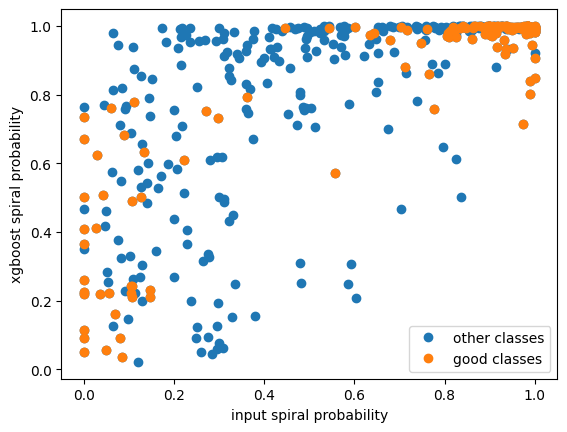

In [73]:
allspec_df['xgb_sp_prob']=allspec_xpred
allspec_dfgood=allspec_df[(allspec_df.spiral==1) | (allspec_df.elliptical==1)]
print(allspec_df.shape,allspec_dfgood.shape)
plt.plot(allspec_df.p_cs_debiased/(allspec_df.p_cs_debiased+allspec_df.p_el_debiased),allspec_df['xgb_sp_prob'],'o',label='other classes')
plt.plot(allspec_dfgood.p_cs_debiased/(allspec_dfgood.p_cs_debiased+allspec_dfgood.p_el_debiased),allspec_dfgood['xgb_sp_prob'],'o',label='good classes')
plt.legend(loc="best")
#plt.title('Test set')
plt.xlabel('input spiral probability')
plt.ylabel('xgboost spiral probability')

Not so clear results. Did everything worked correctly? 

Checking below whether here are more intermediate probabilities than in training set.

In [74]:
print((df.p_cs_debiased/(df.p_cs_debiased+df.p_el_debiased)).quantile([0.28,0.29,0.30]))
print((allspec_dfgood.p_cs_debiased/(allspec_dfgood.p_cs_debiased+allspec_dfgood.p_el_debiased)).quantile([0.23,0.25,0.27]))

0.28    0.475265
0.29    0.551333
0.30    0.609121
dtype: float64
0.23    0.377960
0.25    0.567972
0.27    0.654575
dtype: float64


Is not, thus part worked. Looking now on confusion matrix. 

In [75]:
#45 32 262
#22 15 117 npt exactly double, but a too bog part
x_conf = confusion_matrix(np.round((allspec_dfgood.p_cs_debiased/(allspec_dfgood.p_cs_debiased+allspec_dfgood.p_el_debiased))), np.round(allspec_dfgood['xgb_sp_prob']))
print(x_conf)
x_conf2 = confusion_matrix(np.round((allspec_dfgood.p_cs_debiased/(1))), np.round(allspec_dfgood['xgb_sp_prob']))
print(x_conf2)

[[ 22  15]
 [  0 117]]
[[ 22  15]
 [  0 117]]


Looks clearly different than in training/test data.

In [60]:
#there 6 which are spiral although the probabilties are not
print(339*-0.017699)
print((np.round((allspec_dfgood.p_cs_debiased/(allspec_dfgood.p_cs_debiased+allspec_dfgood.p_el_debiased)))-allspec_dfgood.spiral).describe())
print((np.round(allspec_dfgood.p_cs_debiased)-allspec_dfgood.spiral).describe())

-5.999961
count    339.000000
mean      -0.017699
std        0.132050
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.000000
dtype: float64
count    339.000000
mean      -0.017699
std        0.132050
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.000000
dtype: float64


In [62]:
print(allspec_df['xgb_sp_prob'][0:10])
print(allspec_df.p_cs_debiased[0:10])
print(allspec_df.spiral[0:10])
print(allspec_df.elliptical[0:10])

0    0.780668
1    0.336830
2    0.992943
3    0.997730
4    0.986150
5    0.760384
6    0.805983
7    0.943360
8    0.267084
9    0.862694
Name: xgb_sp_prob, dtype: float64
0    0.725
1    0.153
2    0.682
3    0.504
4    0.175
5    0.058
6    0.647
7    0.072
8    0.148
9    0.605
Name: p_cs_debiased, dtype: float64
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: spiral, dtype: int64
0    0
1    0
2    0
3    0
4    0
5    1
6    0
7    0
8    0
9    0
Name: elliptical, dtype: int64


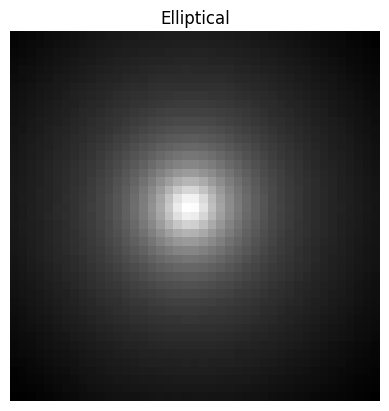

In [63]:
x=5
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

In [64]:
allspec_bad=allspec_dfgood[(np.round(allspec_dfgood.p_cs_debiased)!=np.round(allspec_dfgood['xgb_sp_prob']))]

In [65]:
print(allspec_bad.xgb_sp_prob)
print(allspec_bad.ra)
print(allspec_df.ra.describe())

5      0.760384
24     0.624668
33     0.508323
69     0.733522
80     0.792424
91     0.731413
109    0.502267
153    0.502039
227    0.669451
296    0.778942
301    0.994763
333    0.681720
369    0.608648
379    0.751834
397    0.632778
420    0.760384
439    0.624668
448    0.508323
484    0.733522
495    0.792424
506    0.731413
524    0.502267
568    0.502039
642    0.669451
711    0.778942
716    0.994763
748    0.681720
784    0.608648
794    0.751834
812    0.632778
843    0.619613
850    0.849703
Name: xgb_sp_prob, dtype: float64
5      350.121145
24     350.033638
33     350.230281
69     350.649205
80     350.740539
91     350.845841
109    350.806561
153    351.118286
227    351.264887
296    351.843015
301    351.760498
333    352.210036
369    352.592333
379    352.936124
397    352.922403
420    350.121145
439    350.033638
448    350.230281
484    350.649205
495    350.740539
506    350.845841
524    350.806561
568    351.118286
642    351.264887
711    351.843015
716 

Now looking on some images. One was there already above. 

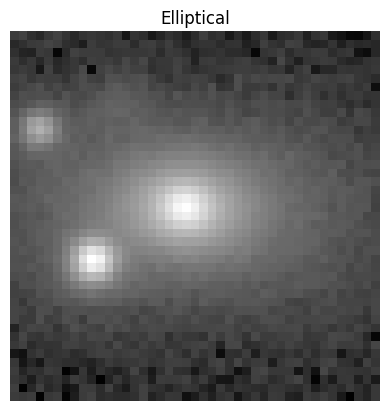

In [66]:
x=24
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

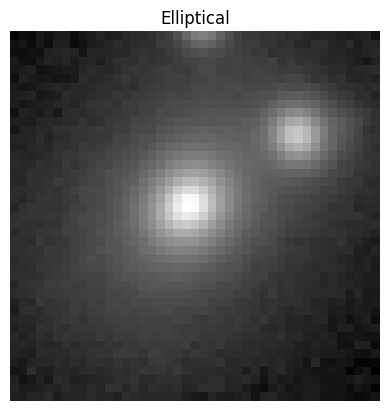

In [67]:
x=33
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

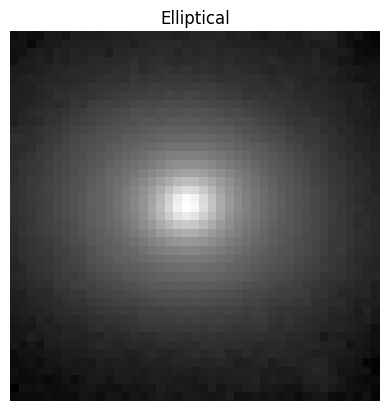

In [215]:
x=69
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

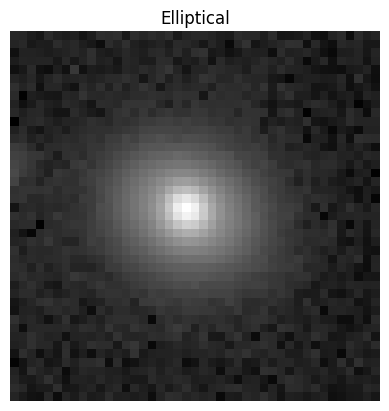

In [216]:
x=80
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

Some have more stars on them, but is that the reason? 

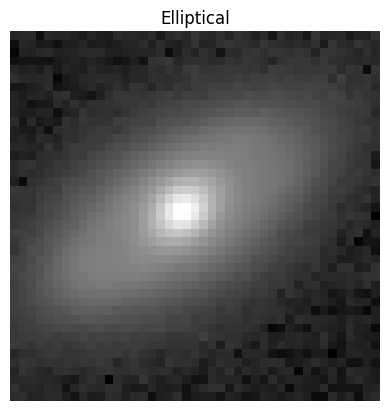

In [209]:
#This one does not look a clear elliptical, [robably a spiral ]
#is also classified as spiral certain  just not from probablity 
x=301
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

One is more likely galaxy but not more. 

Maybe is fine, thus doing convolutional now. 

In [87]:
images_allspec=['stripe82_27_allspec_im.npy']
classes_allspec=['stripe82_27_allspec_table.csv']

allspec_cpred,allspec_df,allspec_images=predict_probs(images_allspec,classes_allspec,'conv2d_2layers_reg0.0001_rotmir_240epochs_v0.pkl',modelname='convolutional',keep_prob=1)

(415, 1, 43, 43)
number of tables is 1
shape of combined data frame (415, 51)
shape of image file is (415, 1, 43, 43)


/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

(415, 1900)
Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type', 'specobjid',
       'class', 'subclass', 'redshift', 'plate', 'mjd', 'fiberid', 'nvote',
       'p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_el_debiased',
       'p_cs_debiased', 'spiral', 'elliptical', 'uncertain', 'image',
       'pixel_x', 'pixel_y', 'off_image', 'mirror_rot'],
      dtype='object')
(415, 52)
(3320, 52) Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r'

/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

(908, 1901) (339, 1901)


/tmp/ipykernel_14447/629800596.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allspec_df['conv_sp_prob']=allspec_cpred


Text(0, 0.5, 'convolutional spiral probability')

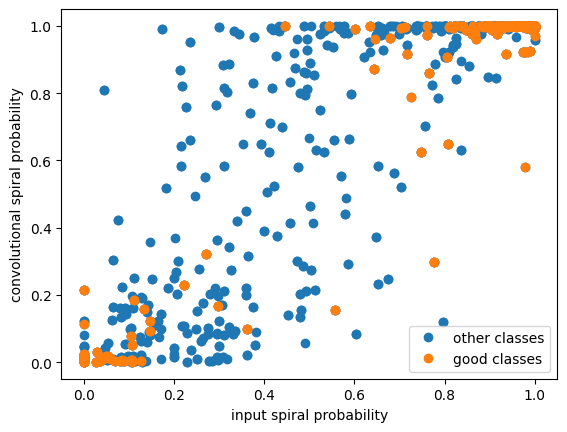

In [69]:
allspec_df['conv_sp_prob']=allspec_cpred
allspec_dfgood=allspec_df[(allspec_df.spiral==1) | (allspec_df.elliptical==1)]
print(allspec_df.shape,allspec_dfgood.shape)
plt.plot(allspec_df.p_cs_debiased/(allspec_df.p_cs_debiased+allspec_df.p_el_debiased),allspec_df['conv_sp_prob'],'o',label='other classes')
plt.plot(allspec_dfgood.p_cs_debiased/(allspec_dfgood.p_cs_debiased+allspec_dfgood.p_el_debiased),allspec_dfgood['conv_sp_prob'],'o',label='good classes')
plt.legend(loc="best")
#plt.title('Test set')
plt.xlabel('input spiral probability')
plt.ylabel('convolutional spiral probability')

Looks clearly better than xgboost. Either random xgboost or a independent problem there. 

In [70]:
c_conf = confusion_matrix(np.round((allspec_dfgood.p_cs_debiased/(allspec_dfgood.p_cs_debiased+allspec_dfgood.p_el_debiased))), np.round(allspec_dfgood['conv_sp_prob']))
print(c_conf)

[[ 75   2]
 [  4 258]]


In [71]:
allspec_cbad=allspec_dfgood[(np.round(allspec_dfgood.p_cs_debiased)!=np.round(allspec_dfgood['conv_sp_prob']))]
print(allspec_cbad.conv_sp_prob)
print(allspec_cbad.p_cs_debiased)
print(allspec_cbad.p_el_debiased)
#last one is a spiral with the one method and not with the other on zoo data
print(allspec_cbad.spiral)

81     0.296902
90     0.155257
301    0.998379
496    0.296902
505    0.155257
716    0.998379
Name: conv_sp_prob, dtype: float64
81     0.777
90     0.528
301    0.446
496    0.777
505    0.528
716    0.446
Name: p_cs_debiased, dtype: float64
81     0.223
90     0.420
301    0.554
496    0.223
505    0.420
716    0.554
Name: p_el_debiased, dtype: float64
81     1
90     1
301    1
496    1
505    1
716    1
Name: spiral, dtype: int64


Looking on the not spirals. 

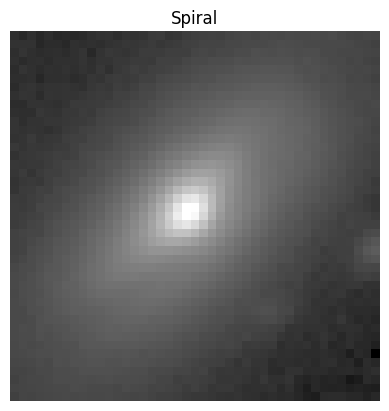

In [22]:
x=81
plt.axis('off')
plt.title(f"Spiral")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

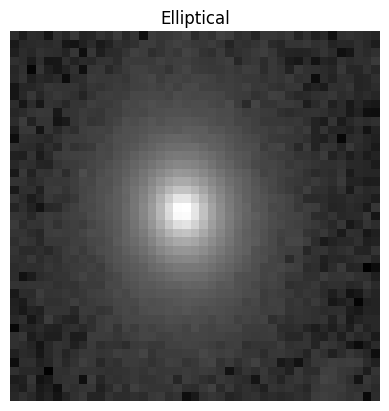

In [23]:
x=90
plt.axis('off')
plt.title(f"Spiral")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

81 is likely a Spiral, althought noit much substructure and so borderline, while 90 seems a clear elliptical.
Looking on more soon. 


Looking on stars. 

In [26]:

images_stars=['stripe82_27_stars_im.npy']
classes_stars=['stripe82_27_stars_table.csv']
stars_cpred,stars_df,stars_images=predict_probs(images_stars,classes_stars,'conv2d_2layers_reg0.0001_rotmir_240epochs_v0.pkl',modelname='convolutional',keep_prob=1)

(599, 1, 43, 43)
number of tables is 1
shape of combined data frame (599, 48)
shape of image file is (599, 1, 43, 43)


/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

(599, 1897)
Index([    'Unnamed: 0',          'index',          'objid',             'ra',
                  'dec',       'psfMag_u',       'psfMag_g',       'psfMag_r',
             'psfMag_i',       'psfMag_z',      'probPSF_u',      'probPSF_g',
            'probPSF_r',      'probPSF_i',      'probPSF_z',     'modelMag_u',
           'modelMag_g',     'modelMag_r',     'modelMag_i',     'modelMag_z',
           'petroRad_g',     'petroRad_r',     'petroRad_i',            'run',
                'rerun',         'camcol',          'field',           'type',
            'specobjid',          'class',       'subclass',       'redshift',
                 'zErr',       'zWarning',     'zErr_noqso', 'zWarning_noqso',
              'z_noqso',     'snMedian_r',     'snMedian_i',       'z_person',
         'class_person',          'plate',            'mjd',        'fiberid',
                'image',        'pixel_x',        'pixel_y',      'off_image',
           'mirror_rot',                

/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

In [ ]:
Looking on probablities.

In [33]:
print(np.argmax(stars_cpred),np.max(stars_cpred),np.mean(stars_cpred),np.median(stars_cpred),stars_cpred[0:20])

429 0.1656909855082631 0.009391265594458957 0.0005097090224808198 [4.98110751e-08 1.32295293e-02 1.04565816e-07 6.69581660e-05
 9.49916107e-06 1.14363121e-09 3.03742255e-02 7.59779867e-05
 4.86873442e-09 6.63652657e-06 4.06305520e-06 1.15760250e-02
 7.75788333e-02 4.35620372e-08 1.60233274e-13 1.16883290e-02
 1.07031414e-02 1.47107326e-02 1.00770598e-03 1.41533961e-02]


All rather elliptical like, not so surprising, since stars have also no substructure. 

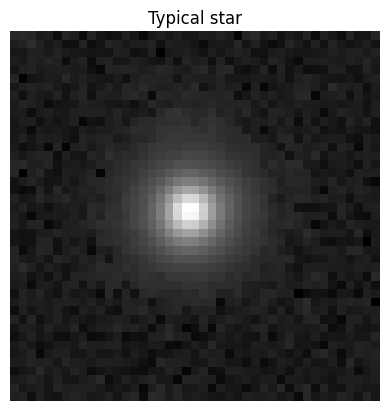

In [36]:
x=18
plt.axis('off')
plt.title(f"Typical star")
plt.imshow(abs(stars_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

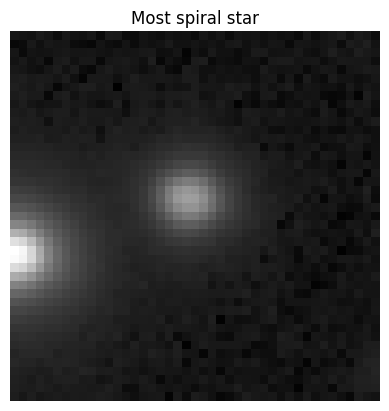

In [37]:
x=429
plt.axis('off')
plt.title(f"Most spiral star")
plt.imshow(abs(stars_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

The stars whose spiral probability is largest, has second bright source in the field, likely another star. Still it is classified as elliptical, giving confindence that the classification is not easily influenced by a second source. 

Next testing how the algorithms are influenced by non proper centereing on a objects.
Needs new function, since object is extracted several times from an image. 

In [77]:
print(allspec_df.shape)

(415, 1901)


In [79]:

allspec_xpred2=predict_probs(images_allspec,classes_allspec,'xgboost_model_spiral_ell_rot_mirr_l2reg3.json',modelname='xgboost',df_output=False,image_output=False)

(415, 1, 43, 43)
number of tables is 1
shape of combined data frame (415, 51)
shape of image file is (415, 1, 43, 43)


/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_14447/2425730463.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

(415, 1900)
Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type', 'specobjid',
       'class', 'subclass', 'redshift', 'plate', 'mjd', 'fiberid', 'nvote',
       'p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_el_debiased',
       'p_cs_debiased', 'spiral', 'elliptical', 'uncertain', 'image',
       'pixel_x', 'pixel_y', 'off_image', 'mirror_rot'],
      dtype='object')
(415, 52)
(3320, 52) Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r'

/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:521: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848],
      dtype='object', length=1849) (415,)


In [113]:
allspec_df['xgb_sp_prob']=allspec_xpred
allspec_df['xgb_sp_prob2']=allspec_xpred2
allspec_dfgood=allspec_df[(allspec_df.spiral==1) | (allspec_df.elliptical==1)]

In [84]:
#gets also a little with certain spiral instead of probabilities. 
x_conf = confusion_matrix(allspec_dfgood.spiral, np.round(allspec_dfgood['xgb_sp_prob']))
print(x_conf)
x_conf2 = confusion_matrix(allspec_dfgood.spiral, np.round(allspec_dfgood['xgb_sp_prob2']))
print(x_conf2)

[[ 22  12]
 [  0 120]]
[[ 34   0]
 [  2 118]]


Gets clearly better with second network and averaging, good. 

Looking on the objects which are neither certain elliptical and spiral galaxy. 
For now especially onbe which combined probability is also low. 

In [119]:
allspec_df['conv_sp_prob']=allspec_cpred
allspec_dfnei=allspec_df[((allspec_df.p_el_debiased+allspec_df.p_cs_debiased)<0.5)]
print(allspec_dfnei.iloc[:,35:44])

     nvote   p_el   p_cw  p_acw  p_edge   p_dk   p_mg  p_el_debiased  \
4       32  0.250  0.000  0.000   0.156  0.094  0.500          0.224   
41      24  0.292  0.000  0.000   0.042  0.125  0.542          0.292   
144     27  0.185  0.037  0.000   0.000  0.000  0.778          0.158   
224     22  0.500  0.045  0.045   0.045  0.136  0.227          0.248   
309     58  0.310  0.000  0.000   0.034  0.172  0.483          0.270   
328     30  0.133  0.067  0.033   0.167  0.100  0.500          0.059   
367     27  0.037  0.074  0.000   0.185  0.593  0.111          0.017   
407     25  0.320  0.000  0.120   0.080  0.480  0.000          0.184   

     p_cs_debiased  
4            0.175  
41           0.042  
144          0.044  
224          0.244  
309          0.046  
328          0.300  
367          0.267  
407          0.267  


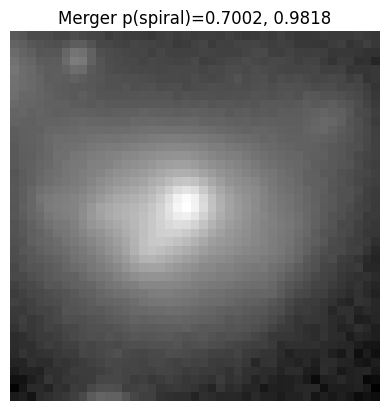

In [116]:
#likely merger
x=4
plt.axis('off')
plt.title(f"Merger p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

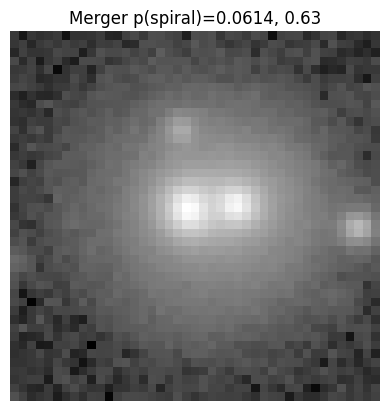

In [117]:
#probably merger
x=41
plt.axis('off')
plt.title(f"Merger p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

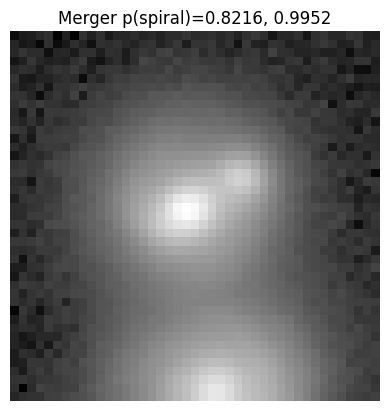

In [118]:
#merger
x=144
plt.axis('off')
plt.title(f"Merger p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

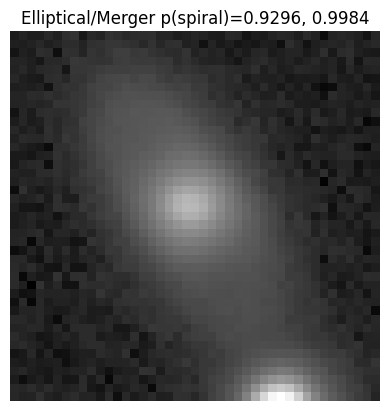

In [120]:
#unclear not elliptical, merger or spiral 
x=224
plt.axis('off')
plt.title(f"Elliptical/Merger p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

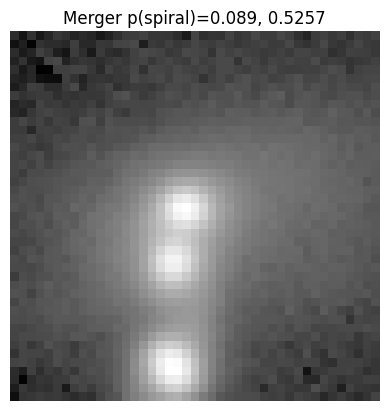

In [121]:
#probably merger
x=309
plt.axis('off')
plt.title(f"Merger p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

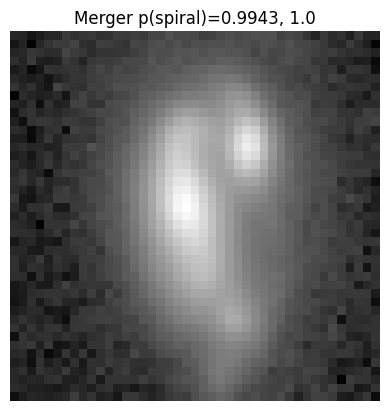

In [122]:
#merger
x=328
plt.axis('off')
plt.title(f"Merger p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

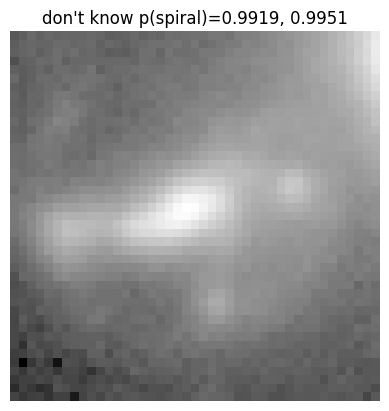

In [123]:
#merger
x=367
plt.axis('off')
plt.title(f"don't know p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

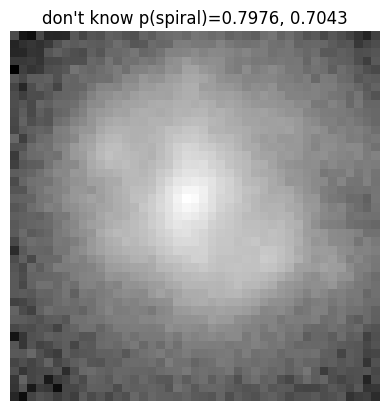

In [124]:
#probably spiral
x=407
plt.axis('off')
plt.title(f"don't know p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

Most of those look like mergers, even when that category is a little less certain and more influenced by the field of view. The galaxies with elongated structures are classified as spiral by xgboost and convolutional while the one is more compact bright stops are usally spirals for xgboost but elliptical for convolutional. 

Now looking on uncertain with similar probabilities for spiral and ellipticals which were classified as uncertain. 

In [129]:
allspec_dfint=allspec_df[(allspec_df.p_el_debiased>0.4) & (allspec_df.p_cs_debiased>0.4) & allspec_df.uncertain==1]
print(allspec_dfint.iloc[:,35:44])

     nvote   p_el   p_cw  p_acw  p_edge   p_dk   p_mg  p_el_debiased  \
14      31  0.581  0.032  0.129   0.161  0.097  0.000          0.453   
16      62  0.694  0.032  0.097   0.065  0.113  0.000          0.444   
46      31  0.516  0.323  0.032   0.129  0.000  0.000          0.457   
48      29  0.621  0.138  0.034   0.172  0.034  0.000          0.428   
54      28  0.536  0.214  0.036   0.143  0.071  0.000          0.483   
102     69  0.594  0.072  0.101   0.232  0.000  0.000          0.424   
126     29  0.793  0.034  0.034   0.069  0.034  0.034          0.416   
146     35  0.771  0.029  0.000   0.143  0.057  0.000          0.460   
165     26  0.769  0.000  0.000   0.154  0.077  0.000          0.437   
188     25  0.680  0.040  0.000   0.240  0.040  0.000          0.400   
205     64  0.891  0.078  0.000   0.016  0.016  0.000          0.463   
208     61  0.852  0.033  0.016   0.049  0.033  0.016          0.455   
241     63  0.778  0.032  0.063   0.079  0.032  0.016          0

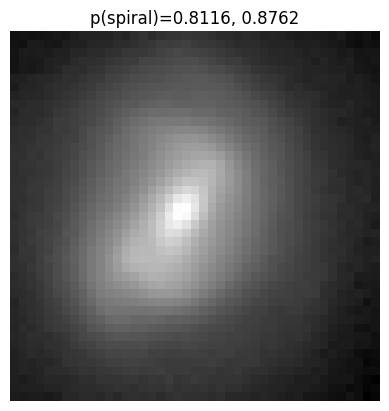

In [131]:
#spiral
x=14
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

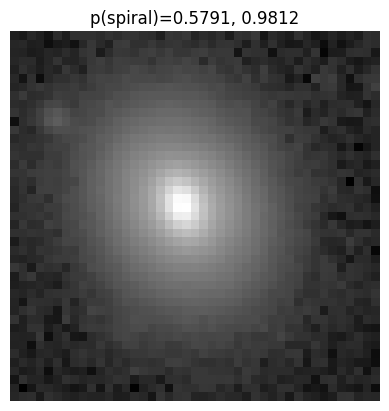

In [132]:
#unclear
x=16
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

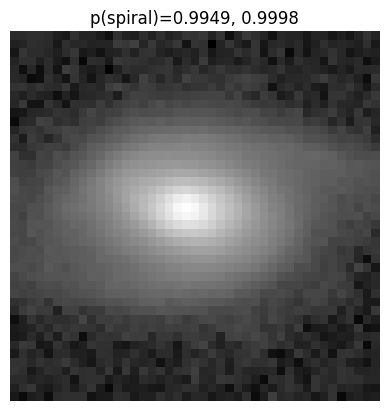

In [133]:
#spiral 
x=46
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

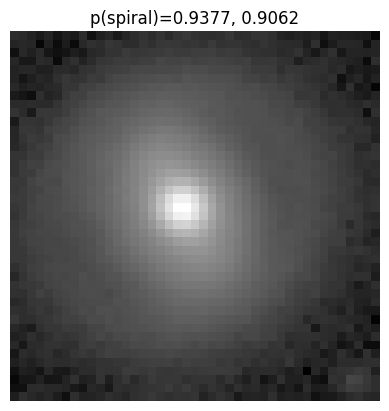

In [135]:
#spiral
x=48
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

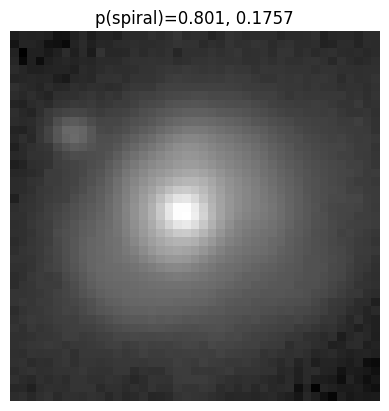

In [136]:
#spiral/merger
x=54
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

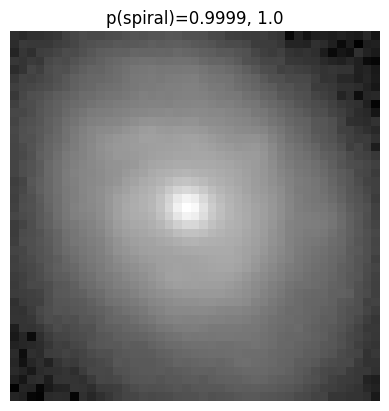

In [138]:
#spiral
x=102
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

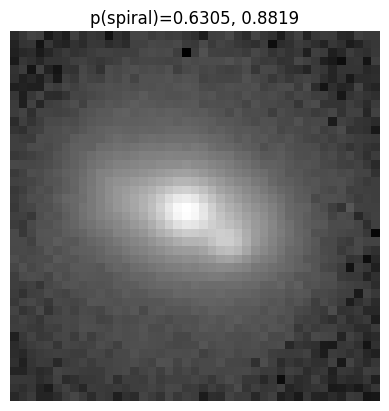

In [139]:
#merger/spiral
x=126
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

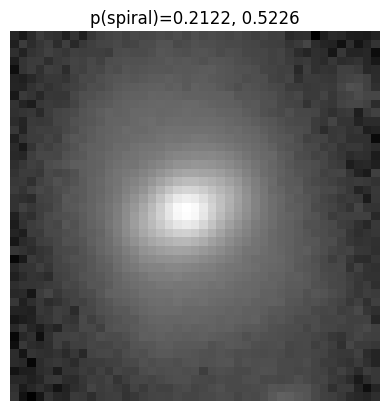

In [140]:
#elliptical?
x=146
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

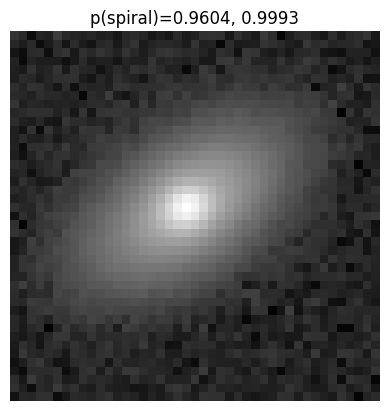

In [141]:
#likely spiral (distant)
x=165
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

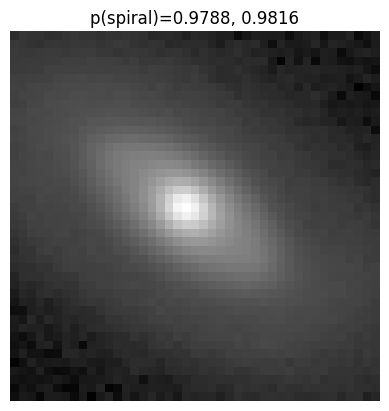

In [142]:
#likely distant spiral
x=188
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

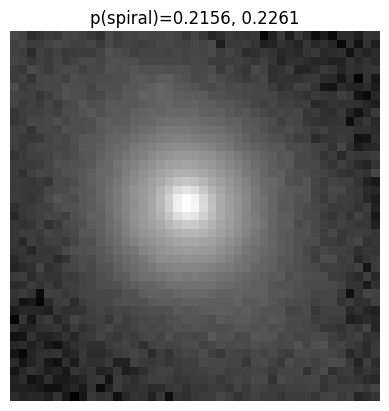

In [143]:
#likely elliptical
x=205
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

In majority cases the algorithm classification for these uncertain agrees with the per eye and is thus improving to the original ones. It does not necessary means that the method is better, since images are deeper.  

In [146]:
allspec_dfconf=allspec_df[((allspec_df.p_el_debiased>allspec_df.p_cs_debiased) & (allspec_df.spiral==1) )| ((allspec_df.p_el_debiased<allspec_df.p_cs_debiased) & (allspec_df.elliptical==1) )]
print(allspec_dfconf.iloc[:,35:47])

     nvote   p_el   p_cw  p_acw  p_edge  p_dk  p_mg  p_el_debiased  \
80      39  0.744  0.000  0.128   0.128   0.0   0.0          0.638   
91      33  0.909  0.000  0.061   0.030   0.0   0.0          0.702   
301     24  0.708  0.042  0.000   0.250   0.0   0.0          0.554   

     p_cs_debiased  spiral  elliptical  uncertain  
80           0.362       1           0          0  
91           0.298       1           0          0  
301          0.446       1           0          0  


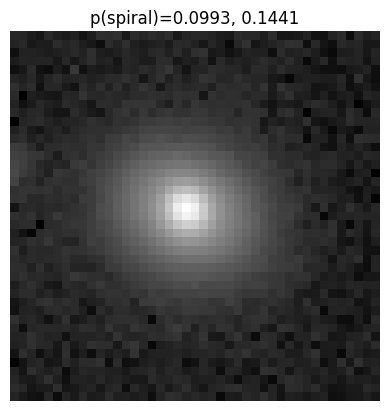

In [147]:
#likely elliptical
x=80
plt.axis('off')
plt.title(f"Spiral p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

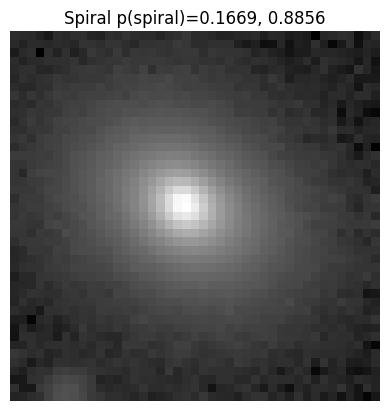

In [148]:
#elliptical
x=91
plt.axis('off')
plt.title(f"Spiral p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

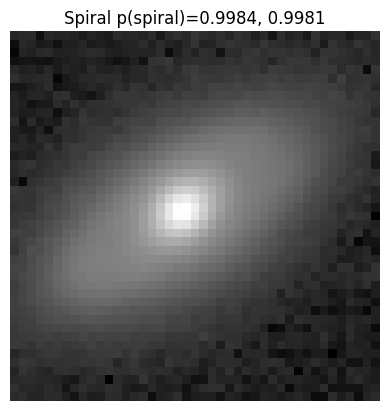

In [149]:
#spiral 
x=301
plt.axis('off')
plt.title(f"Spiral p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob2[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')